<h1><center>SimpleITK Tutorial</center></h1>

# Transforming Images with SimpleITK

Author: José D. Tascón-Vidarte \
Email: jota@di.ku.dk \
University of Copenhagen

Objectives:
- Learn how to apply transformations to images with SimpleITK

The documentation of SimpleITK is available at https://itk.org/SimpleITKDoxygen100/html/index.html

This tutorial is based on the Notebooks provided by the Insight Software Consortium. http://insightsoftwareconsortium.github.io/SimpleITK-Notebooks/

##  Cloning files

Open the files to be used from github.

In [4]:
# !rm -rf /content/registration_tutorial/
# !git clone https://github.com/josetascon/registration_tutorial.git

## Import libraries
Import the libraries to be used.

In [1]:
# !pip install simpleitk           # install simpleitk in colabs

import SimpleITK as sitk         # simpleitk library
import sys                       # sys library, used to include local py files
import numpy as np               # array and matrix library
import matplotlib.pyplot as plt  # plot library

from ipywidgets import interact, fixed # jupyter widgets libraries

# sys.path.insert(0, '/content/registration_tutorial/') # local library path
from local_utils import image_info, imshow_2d # local file local_utils.py

SimpleITK support every transformation in 2D or 3D. Examples here in 2D to simplify. 

## Selection of an Image

All the transformations presented here can be applied to a set of images defined here. These images show how the transformation affect the region of interest. The images are:

* grid.png: image with a grid pattern in black and white.
* sinc.png: image with a 2D sinc function
* geometric.png: image with geometric primitives such as rentangles, triangles and circles.
* 'file'_pad.png: image with extra pixels around the borders to observe trasnformations.  

In [2]:
def image_select(list_images):
    # Function to be called with interact to select one image from the list_images
    # Input: list_images (list of strings with file names)
    # Output: None
    global img # variable to store the image to be used for all operations in this notebook
    prefix = './images/'
    img = sitk.ReadImage(prefix + list_images, sitk.sitkFloat64)
    print(image_info(img))
    imshow_2d(img)
    return

In [3]:
dimension = 2

global img # variable to store the image to be used for all operations in this notebook

list_images = ['grid.png', 'grid_pad.png', 'sinc.png',
            'sinc_pad.png', 'geometric.png', 'geometric_pad.png']

interact(image_select, list_images = list_images);

# Colabs code
# selection = 0
# prefix = '/content/registration_tutorial/images/' # colabs path
# img = sitk.ReadImage(prefix + list_images[selection], sitk.sitkFloat64)
# print(image_info(img))
# imshow_2d(img)

interactive(children=(Dropdown(description='list_images', options=('grid.png', 'grid_pad.png', 'sinc.png', 'si…

## Utils Functions to Transform Images

Similar to the utility functions for images, here a set of functions to use transformations is defined.

In [4]:
def get_name_transform( str_transform ):
    # Return class name of transformation using its string object
    # Input: string (transform.ToString())
    # Output: string
    name = str_transform.split()
    return name[1] # transform class name always in second line

def transform_info( transform ):
    # Return a string with information about the transformation.
    # Input: sitk.Transform
    # Output: string
    info = '\n===== Transform Info ====='
    info += '\nTransform type: \t' + get_name_transform(str(transform))
    info += '\nDimensions: \t\t' + str(transform.GetDimension())
    info += '\nParameters: \t\t' + str(transform.GetParameters())
    info += '\n'
    return info

def transform_point(point, transform, verbose = True):
    # Apply a transformation to a point
    # Inputs: tuple, sitk.Transform, bool 
    # Output: tuple
    transformed_point = transform.TransformPoint(point)
    if verbose:
        info = '\n===== Transform Point ====='
        info += '\nPoint: \t\t' + str(point)
        info += '\nTransformed: \t' + str(transformed_point)
        info += '\n'
        print(info)
    return transformed_point

def transform_image(image, transform, interpolator = sitk.sitkLinear, default_value = 0.0):
    # Apply a transform to an image
    # Inputs: sitk.Image, sitk.Transform, sitk.InterpolatorEnum, double
    # Output: sitk.Image
    reference_image = image
    return sitk.Resample(image, reference_image, transform, interpolator, default_value)

These functions can be used to apply transformation with SimpleITK.

<b>Note:</b> These functions are stored in a local file called [local_utils.py](./local_utils.py) for further usage.

## Global Transformations

In this notebook global transformation are used and applied to images.
The following transformation are covered:
* Translation
* Rotation
* Euler (Rotation + Translation)
* Affine

## Translation Transform

A translation is a transformation where each coordinate value is displaced by a translation value. This is represented as:

\begin{equation*}
    \mathbf{x}_{2} = \mathbf{x}_{1} + \mathbf{b}  
\end{equation*}

Equivalent in vector form:
\begin{equation*}
    \begin{pmatrix}
    x_{2}\\
    y_{2}
    \end{pmatrix}=
    \begin{pmatrix}
    x_{1}\\
    y_{1}
    \end{pmatrix} +
    \begin{pmatrix}
    b_{x} \\
    b_{y}
    \end{pmatrix}
\end{equation*}

Therefore, each point in the image $I_1$ is translated to a new position in image $I_2$.

Here, we create a translation transform and set its parameters.


In [5]:
# Create a new translation transform
translation = sitk.TranslationTransform(dimension)
print(transform_info(translation))

# Set the parameteres
translation.SetParameters((20,-10))
print(transform_info(translation))


===== Transform Info =====
Transform type: 	TranslationTransform
Dimensions: 		2
Parameters: 		(0.0, 0.0)


===== Transform Info =====
Transform type: 	TranslationTransform
Dimensions: 		2
Parameters: 		(20.0, -10.0)



Translation of a point

In [6]:
# Translate a point and print the results
point = (1.0, 3.0)
translation.SetParameters((-10,7))
new_point = transform_point(point, translation)


===== Transform Point =====
Point: 		(1.0, 3.0)
Transformed: 	(-9.0, 10.0)



Translation of a image

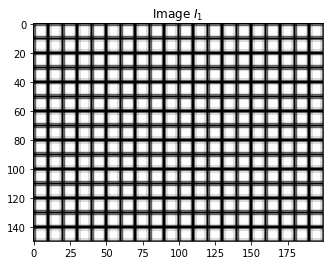

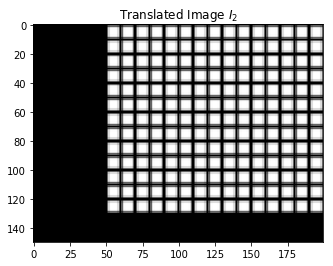

In [7]:
# Use the transform_image function
translation.SetParameters((-50,20))
img_t = transform_image(img, translation)

# Show the images
imshow_2d(img, "Image $I_1$", axis=True) 
imshow_2d(img_t, "Translated Image $I_2$", axis=True) # active axis to see the shift

Interacting with translation transform.

A function is defined here to change on-line the translation parameter.

In [8]:
def imshow_translation(bx, by, image_itk ):
    # Function to translate an image on-line. Intended to be use with interact (Jupyter)
    # Inputs:
    #     int bx, translation in the x direction
    #     int by, translation in the y direction
    #     sitk.Image
    # Output: None
    dimension =  image_itk.GetDimension()
    translation = sitk.TranslationTransform(dimension)
    translation.SetParameters((bx, by)) # set the translation parameters
    image_tt = transform_image(image_itk,translation)
    imshow_2d(image_tt, 'Translated Image')
    return

# Use image size (depth and width) to obtain maximum range of translations.
w = img.GetWidth()
h = img.GetHeight()
interact(imshow_translation, bx = (-w,w), by = (-h,h), image_itk = fixed(img));

interactive(children=(IntSlider(value=0, description='bx', max=200, min=-200), IntSlider(value=0, description=…

## Rotation Transform

A rotation is a transformation where each coordinate value is displaced by a defined angle with regards to the origin. This is represented as:

\begin{equation*}
    \mathbf{x_2} = \mathbf{R} \cdot \mathbf{x}_1
\end{equation*}

Equivalent in vector form:
\begin{equation*}
    \begin{pmatrix}
    x_{2}\\
    y_{2}
    \end{pmatrix}=
    \begin{bmatrix}
    \cos{\theta} & -\sin{\theta}  \\
    \sin{\theta} & \cos{\theta}
    \end{bmatrix}
    \begin{pmatrix}
    x_{1}\\
    y_{1}
    \end{pmatrix}
\end{equation*}

Therefore, each point in the image $I_1$ is rotated an angle $\theta$ to a new position in image $I_2$

A rotation matrix is an ortoghonal matrix that satisfy $det(\mathbf{R}) = 1$. This kind of matrix have the property $\mathbf{R}\cdot\mathbf{R}^T = \mathbf{I}$

SimpleITK does not have a single rotation transformation. Rotation is included in the more general euclidean transformation. This is covered in the following section.

In [9]:
# Create an Euler Transformation
rotation = sitk.Euler2DTransform()
print(transform_info(rotation))

# Set only the first parameter, related to angle in radians units
rotation.SetParameters((np.pi/2,0,0))
print(transform_info(rotation))


===== Transform Info =====
Transform type: 	Euler2DTransform
Dimensions: 		2
Parameters: 		(0.0, 0.0, 0.0)


===== Transform Info =====
Transform type: 	Euler2DTransform
Dimensions: 		2
Parameters: 		(1.5707963267948966, 0.0, 0.0)



Rotation of a point

In [10]:
# Rotate a point and print the results
point = (8.0, -8.0)
rotation.SetParameters((-np.pi/6,0,0))
new_point = transform_point(point, rotation)


===== Transform Point =====
Point: 		(8.0, -8.0)
Transformed: 	(2.92820323027551, -10.928203230275509)



Rotation of a image

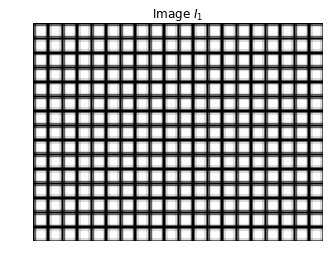

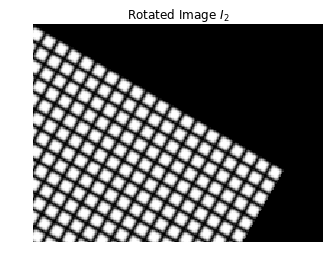

In [11]:
# Use the transform_image function
rotation.SetParameters((-np.pi/6,0,0))
img_r = transform_image(img, rotation)

# Show the results
imshow_2d(img, "Image $I_1$")
imshow_2d(img_r, "Rotated Image $I_2$")

Interacting with rotation

In [12]:
def imshow_rotation(angle, image_itk ):
    # Function to rotate an image on-line. Intended to be use with interact (Jupyter)
    # Inputs:
    #     int angle, rotation angle in degrees
    #     sitk.Image
    # Output: None
    dimension =  image_itk.GetDimension()
    rotation = sitk.Euler2DTransform()
    rotation.SetParameters((angle*np.pi/180.0, 0.0, 0.0))
    image_tt = transform_image(image_itk,rotation)
    imshow_2d(image_tt, 'Rotated Image')
    
interact(imshow_rotation, angle = (-180,180), image_itk = fixed(img));

interactive(children=(IntSlider(value=0, description='angle', max=180, min=-180), Output()), _dom_classes=('wi…

## Euclidean Transform

A euclidean transformation is a combined rotation and translation where each coordinate value is rotated and then translated. This is represented as:


\begin{equation*}
    \mathbf{x_2} = \mathbf{R} \cdot \mathbf{x}_1 + \mathbf{b}
\end{equation*}

Equivalent in vector form:
\begin{equation*}
    \begin{pmatrix}
    x_{2}\\
    y_{2}
    \end{pmatrix}=
    \begin{bmatrix}
    \cos{\theta} & -\sin{\theta}  \\
    \sin{\theta} & \cos{\theta}
    \end{bmatrix}
    \begin{pmatrix}
    x_{1}\\
    y_{1}
    \end{pmatrix}+
    \begin{pmatrix}
    b_{x} \\
    b_{y}
    \end{pmatrix}
\end{equation*}

Therefore, each point in the image $I_1$ is rotated an angle $\theta$ and then translated to a new position in image $I_2$


In [13]:
# Create an Euler Transformation
rigid2d = sitk.Euler2DTransform()
print(transform_info(rigid2d))

# Set the trasnformation parameters (angle, bx, by)
rigid2d.SetParameters((np.pi/2,-12,-15))
print(transform_info(rigid2d))


===== Transform Info =====
Transform type: 	Euler2DTransform
Dimensions: 		2
Parameters: 		(0.0, 0.0, 0.0)


===== Transform Info =====
Transform type: 	Euler2DTransform
Dimensions: 		2
Parameters: 		(1.5707963267948966, -12.0, -15.0)



Euclidean transformation of a point

In [14]:
# Apply the euclidean transform a point
point = (0.0, 10.0)
rigid2d.SetParameters((-np.pi/6,4,-2))
new_point = transform_point(point, rigid2d)


===== Transform Point =====
Point: 		(0.0, 10.0)
Transformed: 	(9.0, 6.660254037844387)



Euclidean transformation of a image

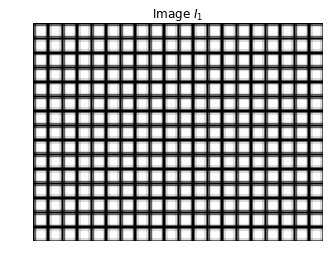

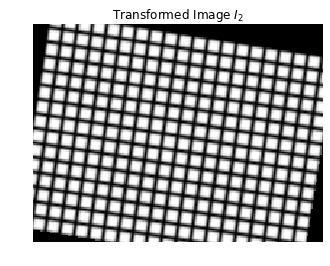

In [15]:
# Transform an image
rigid2d.SetParameters((-np.pi/20,-10,10))
img_r = transform_image(img, rigid2d)

# Show the result
imshow_2d(img, "Image $I_1$")
imshow_2d(img_r, "Transformed Image $I_2$")

Interacting with euclidean transformation

In [16]:
def imshow_rigid(angle, bx, by, image_itk ):
    # Function to rigid transform an image on-line. Intended to be use with interact (Jupyter)
    # Inputs:
    #     int angle, rotation angle in degrees
    #     int bx, translation in x direction
    #     int by, translation in y direction
    #     sitk.Image
    # Output: None
    dimension =  image_itk.GetDimension()
    rigid2d = sitk.Euler2DTransform()
    rigid2d.SetParameters((angle*np.pi/180.0, bx, by))
    image_tt = transform_image(image_itk,rigid2d)
    imshow_2d(image_tt, 'Transformed Image')

# Use image size (depth and width) to obtain maximum range of translations.
w = img.GetWidth()
h = img.GetHeight()
interact(imshow_rigid, angle = (-180,180), bx = (-w,w), by = (-h,h),
         image_itk = fixed(img));

interactive(children=(IntSlider(value=0, description='angle', max=180, min=-180), IntSlider(value=0, descripti…

## Affine Transform

An affine transformation is a combined scale, shear and translation where each coordinate value is scaled-sheared and then translated. This is represented as:


\begin{equation*}
    \mathbf{x_2} = \mathbf{A} \cdot \mathbf{x}_1 + \mathbf{b}
\end{equation*}

Equivalent in vector form:
\begin{equation*}
    \begin{pmatrix}
    x_{2}\\
    y_{2}
    \end{pmatrix}=
    \begin{bmatrix}
    scale_x & shear_y  \\
    shear_x & scale_y
    \end{bmatrix}
    \begin{pmatrix}
    x_{1}\\
    y_{1}
    \end{pmatrix}+
    \begin{pmatrix}
    b_{x} \\
    b_{y}
    \end{pmatrix}
\end{equation*}

Therefore, each point in the image $I_1$ is rotated an angle $\theta$ and then translated to a new position in image $I_2$.

An affine transformation have the property that all paralles lines preserve this condition.

As can be seen, an affine matrix $A$ is a generalization of a 2D transformation. A rotation is a particular case of an affine transformation.


In [17]:
# Create an affine transformation
affine = sitk.AffineTransform(dimension)
print(transform_info(affine))

# Set the transformation parameters (scalex, sheary, shearx, scaley, bx, by)
affine.SetParameters((1,2,2,1,-12,-15))
print(transform_info(affine))


===== Transform Info =====
Transform type: 	AffineTransform
Dimensions: 		2
Parameters: 		(1.0, 0.0, 0.0, 1.0, 0.0, 0.0)


===== Transform Info =====
Transform type: 	AffineTransform
Dimensions: 		2
Parameters: 		(1.0, 2.0, 2.0, 1.0, -12.0, -15.0)



Affine transformation of a point

In [18]:
# Apply a transformation to a point
point = (2.0, -4.0)
affine.SetParameters((1,2,2,1,-12,-15))
new_point = transform_point(point, affine)


===== Transform Point =====
Point: 		(2.0, -4.0)
Transformed: 	(-18.0, -15.0)



Affine transformation of an image

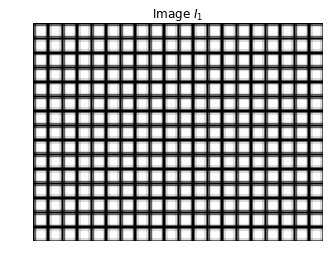

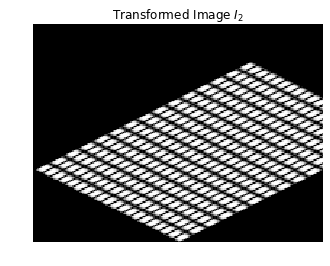

In [19]:
# Apply the transformation
affine.SetParameters((1,2,-0.5,1,-200,50))
img_t = transform_image(img, affine)

# Show the result
imshow_2d(img, "Image $I_1$")
imshow_2d(img_t, "Transformed Image $I_2$")

Interacting with an affine transformation

In [20]:
def imshow_affine(scx, shx, shy, scy, bx, by, image_itk ):
    # Function to affine transform an image on-line. Intended to be use with interact (Jupyter)
    # Inputs:
    #     int scx, scale in x axis
    #     int shx, shear in x direction
    #     int shy, shear in x direction
    #     int scy, scale in x axis
    #     int bx, translation in x direction
    #     int by, translation in y direction
    #     sitk.Image
    # Output: None
    dimension =  image_itk.GetDimension()
    affine = sitk.AffineTransform(dimension)
    affine.SetParameters((scx, shx, shy, scy, bx, by)) #set the parameters
    image_tt = transform_image(image_itk,affine)
    imshow_2d(image_tt, 'Transformed Image')
    
# use image width and heigth as range of translations
w = img.GetWidth()
h = img.GetHeight()
m = 3 # scale reference value
s = 2 # shear reference value
interact(imshow_affine, scx = (-m,m+2,0.25), shx = (-s,s,0.25), 
         shy = (-s,s,0.25), scy = (-m,m+2,0.25),
         bx = (-w,w), by = (-h,h), image_itk = fixed(img));

interactive(children=(FloatSlider(value=1.0, description='scx', max=5.0, min=-3.0, step=0.25), FloatSlider(val…

## Inverse Transformation

An inverse transformation can be applied to any image in order to reverse the process. SimpleITK compute automaticaly the inverse of any transformation.

In this example an affine transformation is applied to an image, an is followed by a reverse transformation of this image.

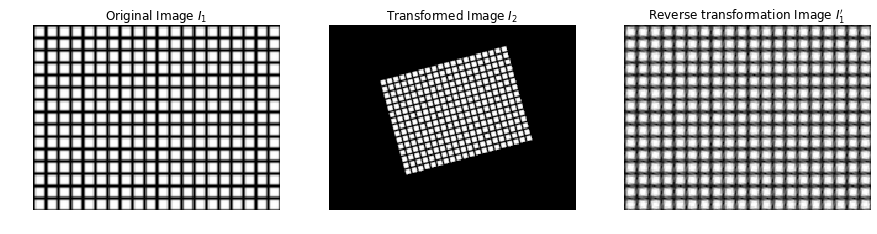

In [21]:
# Create an affine transformation
affine = sitk.AffineTransform(dimension)
affine.SetParameters((1.8,-0.5,0.5,1.8,-50,-100))
inverse =  affine.GetInverse()

# Apply the transformations
img_t = transform_image(img, affine, interpolator=sitk.sitkLinear)  # Affine trasnformation
img_i = transform_image(img_t, inverse, interpolator=sitk.sitkLinear) # Inverse transformation

# Show the result
f, axs = plt.subplots(1,3,figsize=(15,8))
plt.subplot(131)
imshow_2d(img, "Original Image $I_1$", show=False)
plt.subplot(132)
imshow_2d(img_t, "Transformed Image $I_2$", show=False)
plt.subplot(133)
imshow_2d(img_i, "Reverse transformation Image $I_1'$", show=False)
plt.show()

As can be seen in the previous images. There is a loss in quality of the image. In particular, for a scaling the loss is irreversible due to resolution error. However, there is a numerical issue related to interpolation. SimpleITK supports several interpolation methods. See [interpolation options](https://itk.org/SimpleITKDoxygen100/html/namespaceitk_1_1simple.html#a7cb1ef8bd02c669c02ea2f9f5aa374e5)

## Composite Transformation

SimpleITK supports multiple transformations to be applied to at once. This is performed with a composite transformation where multiple transforms are put together into a single transform object.  With a composite transform, multiple resampling operations are prevented, so interpolation errors are not accumulated.  For example, a rotation about a specific point.

### Rotation about a point

Changing the center of coordinates to the mid point in the image in order to rotate. This transformation is achieved with the next expresion.

\begin{equation*}
    \mathbf{x_2} = (\mathbf{R} \cdot (\mathbf{x}_1 - \mathbf{p})) + \mathbf{p}
\end{equation*}

The composite transform works as a stack, last in first out (applied). In this example we rotate the image around the center of coordinates.


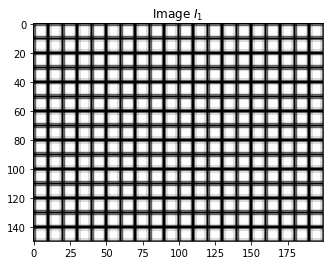

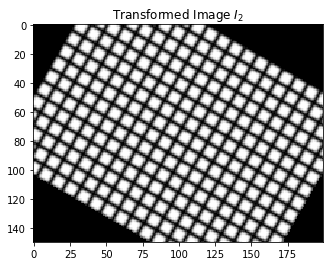

In [22]:
# Transformations
t1 = sitk.Euler2DTransform()
t2 = sitk.Euler2DTransform()
t3 = sitk.Euler2DTransform() 

size = img.GetSize()
center = (size[0]//2, size[1]//2) # Get the center of coordinates

# Transformations
t1.SetParameters((0,-center[0],-center[1])) # Shift the center of the image to coordinate (0,0)
t2.SetParameters((-np.pi/6,0,0))            # Rotate the image
t3.SetParameters((0,center[0],center[1]))   # Shift back

# Composite transformation
compose_t = sitk.Transform(t3) # Last transformation to be applied
compose_t.AddTransform(t2)     # Rotation transform
compose_t.AddTransform(t1)     # First tranformation to apply, last to insert in the composition

# Show the transformations
img_t = transform_image(img, compose_t)
imshow_2d(img, "Image $I_1$", axis=True)
imshow_2d(img_t, "Transformed Image $I_2$", axis=True)

## Writing and Reading Transformation Files

SimpleITK allows to store tranformations in files. The transformations can be single or composite transformations. The typical format of a transformation is '.tfm'.

The following example write a transformation in a file.

In [23]:
# Define a transformation to be stored
t1 = sitk.Euler2DTransform()
t1.SetParameters((np.pi/3,50.007,-49.101))
print(transform_info(t1))

prefix = './output/'
# prefix = '/content/registration_tutorial/' # colabs path
file = 'transform1.tfm'
sitk.WriteTransform(t1, prefix + file) # Write the transformation in a file


===== Transform Info =====
Transform type: 	Euler2DTransform
Dimensions: 		2
Parameters: 		(1.0471975511965976, 50.007, -49.101)



Lets see what is stored in the file. The information is shown as plain text.

In [24]:
file_mhd = open(prefix + file,'r') # open the file as a regular text file
print(file_mhd.read())                               # Detail the header content
file_mhd.close()

#Insight Transform File V1.0
#Transform 0
Transform: Euler2DTransform_double_2_2
Parameters: 1.0471975511965976 50.007 -49.101
FixedParameters: 0 0



Reading the file back.

In [25]:
# Read back the file
t2 = sitk.ReadTransform(prefix + file)
print(transform_info(t2))


===== Transform Info =====
Transform type: 	Euler2DTransform
Dimensions: 		2
Parameters: 		(1.0471975511965976, 50.007, -49.101)



Writing and reading composite transforms.

In [26]:
# Transformations
rigid1 = sitk.Euler2DTransform()
affine2 = sitk.AffineTransform(dimension)

# Transformations
rigid1.SetParameters((np.pi,5,10)) # Rigid parameters
affine2.SetParameters((1,0.5,0,1,20,30))            # Rotate the image

# Composite transformation
compose1 = sitk.Transform(affine2) # Affine transformation
compose1.AddTransform(rigid1)     # Rigid transformation

# Write the transformation in a file
prefix = './output/'
# prefix = '/content/registration_tutorial/' # colabs path
file = 'transform1.tfm'
sitk.WriteTransform(compose1, prefix + file) 

# Read back the file
compose2 = sitk.ReadTransform(prefix + file)
print(compose2)

itk::simple::Transform
 CompositeTransform (0x55db6b019df0)
   RTTI typeinfo:   itk::CompositeTransform<double, 2u>
   Reference Count: 1
   Modified Time: 1701
   Debug: Off
   Object Name: 
   Observers: 
     none
   Transforms in queue, from begin to end:
   >>>>>>>>>
   AffineTransform (0x55db6cd82790)
     RTTI typeinfo:   itk::AffineTransform<double, 2u>
     Reference Count: 1
     Modified Time: 1691
     Debug: Off
     Object Name: 
     Observers: 
       none
     Matrix: 
       1 0.5 
       0 1 
     Offset: [20, 30]
     Center: [0, 0]
     Translation: [20, 30]
     Inverse: 
       1 -0.5 
       1.11022e-16 1 
     Singular: 0
   >>>>>>>>>
   Euler2DTransform (0x55db6c691b50)
     RTTI typeinfo:   itk::Euler2DTransform<double>
     Reference Count: 1
     Modified Time: 1696
     Debug: Off
     Object Name: 
     Observers: 
       none
     Matrix: 
       -1 -1.22465e-16 
       1.22465e-16 -1 
     Offset: [5, 10]
     Center: [0, 0]
     Translation: [5, 10]
  